# Model Evaluation: LeakyReLU 03 Results

This notebook evaluates the trained models from `results leakyrelu 03/` folder on train, validation, and test datasets.
- Class-wise performance metrics
- Confusion matrices with accuracy-based coloring
- Comparative analysis across all three optimizers (Adam, SGD, SGD+Momentum)

## 1. Setup and Imports

In [20]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


## 2. Configuration

In [21]:
# Paths
MODEL_DIR = 'results leakyrelu 03/models'
DATA_DIR = 'dataloader'
OUTPUT_DIR = 'results leakyrelu 03/evaluation'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model names
MODEL_NAMES = [
    'best_model_WasteCustom_Adam.pth',
    'best_model_WasteCustom_SGD.pth',
    'best_model_WasteCustom_SGD_Momentum.pth'
]

print(f"Model directory: {MODEL_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Models to evaluate: {MODEL_NAMES}")

Model directory: results leakyrelu 03/models
Data directory: dataloader
Output directory: results leakyrelu 03/evaluation
Models to evaluate: ['best_model_WasteCustom_Adam.pth', 'best_model_WasteCustom_SGD.pth', 'best_model_WasteCustom_SGD_Momentum.pth']


## 3. Model Architecture Definition

In [22]:
class WasteCustom(nn.Module):
    """Custom CNN for Waste Classification with LeakyReLU activation"""
    def __init__(self, num_classes=9):
        super(WasteCustom, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive pooling and flatten
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(8192, 512)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation
        self.relu = nn.LeakyReLU()
    
    def forward(self, x):
        # Conv block 1
        x = self.pool1(self.relu(self.conv1(x)))
        
        # Conv block 2
        x = self.pool2(self.relu(self.conv2(x)))
        
        # Conv block 3
        x = self.pool3(self.relu(self.conv3(x)))
        
        # Adaptive pooling and flatten
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Test model instantiation
test_model = WasteCustom(num_classes=NUM_CLASSES)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"Model Architecture: WasteCustom CNN with LeakyReLU")
print(f"Total Parameters: {total_params:,}")
print(f"Model successfully defined!")

Model Architecture: WasteCustom CNN with LeakyReLU
Total Parameters: 4,292,681
Model successfully defined!


## 4. Data Loaders

In [23]:
def get_data_loaders(data_dir, image_size, batch_size):
    """Create data loaders for train, validation, and test sets"""
    
    # Transform for all datasets (no augmentation for evaluation)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'),
        transform=transform
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'val'),
        transform=transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'),
        transform=transform
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Load data
train_loader, val_loader, test_loader, class_names = get_data_loaders(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)

print(f"\nDataset Statistics:")
print(f"  Training samples: {len(train_loader.dataset):,}")
print(f"  Validation samples: {len(val_loader.dataset):,}")
print(f"  Test samples: {len(test_loader.dataset):,}")
print(f"\nClasses ({len(class_names)}):")
for i, cls in enumerate(class_names):
    print(f"  {i}: {cls}")


Dataset Statistics:
  Training samples: 4,626
  Validation samples: 1,828
  Test samples: 1,859

Classes (9):
  0: Cardboard
  1: Food Organics
  2: Glass
  3: Metal
  4: Miscellaneous Trash
  5: Paper
  6: Plastic
  7: Textile Trash
  8: Vegetation


## 5. Evaluation Functions

In [24]:
def evaluate_model(model, dataloader, device):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)


def get_class_wise_metrics(y_true, y_pred, class_names):
    """Calculate class-wise precision, recall, f1-score, and accuracy"""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Calculate per-class accuracy
    class_accuracies = []
    for i in range(len(class_names)):
        mask = y_true == i
        if mask.sum() > 0:
            class_acc = (y_pred[mask] == y_true[mask]).sum() / mask.sum()
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0.0)
    
    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_accuracies,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    return metrics_df


def plot_confusion_matrix(y_true, y_pred, class_names, title, save_path=None, figsize=(12, 10)):
    """Plot confusion matrix with accuracy-based coloring (white to blue)"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy for each cell (normalized by true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap with accuracy values as colors - Blues colormap
    # White = low accuracy (0), Dark Blue = high accuracy (1)
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Accuracy'},
                vmin=0, vmax=1, ax=ax, linewidths=0.5, linecolor='gray')
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Rotate labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    return cm, cm_normalized

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


## 6. Load and Evaluate Models

We'll evaluate each model (Adam, SGD, SGD+Momentum) on train, validation, and test sets.

In [25]:
# Dictionary to store all results
results = {}

# Evaluate each model
for model_name in MODEL_NAMES:
    model_path = os.path.join(MODEL_DIR, model_name)
    
    # Extract optimizer name from model filename
    if 'Adam' in model_name:
        optimizer_name = 'Adam'
    elif 'SGD_Momentum' in model_name:
        optimizer_name = 'SGD+Momentum'
    elif 'SGD' in model_name:
        optimizer_name = 'SGD'
    else:
        optimizer_name = 'Unknown'
    
    print(f"\n{'='*80}")
    print(f"Evaluating Model: {optimizer_name}")
    print(f"Model Path: {model_path}")
    print(f"{'='*80}")
    
    # Load model
    model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"✓ Model loaded successfully")
    
    # Initialize results dictionary for this model
    results[optimizer_name] = {}
    
    # Evaluate on each dataset
    for dataset_name, dataloader in [('Train', train_loader), 
                                      ('Validation', val_loader), 
                                      ('Test', test_loader)]:
        print(f"\n--- Evaluating on {dataset_name} Set ---")
        
        # Get predictions
        y_pred, y_true = evaluate_model(model, dataloader, DEVICE)
        
        # Calculate overall accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Get class-wise metrics
        metrics_df = get_class_wise_metrics(y_true, y_pred, class_names)
        
        # Store results
        results[optimizer_name][dataset_name] = {
            'accuracy': accuracy,
            'y_true': y_true,
            'y_pred': y_pred,
            'metrics_df': metrics_df
        }
        
        # Save metrics to CSV
        csv_path = os.path.join(OUTPUT_DIR, f'{optimizer_name}_{dataset_name}_classwise_metrics.csv')
        metrics_df.to_csv(csv_path, index=False)
        print(f"✓ Class-wise metrics saved to: {csv_path}")
    
    print(f"\n✓ Completed evaluation for {optimizer_name}")

print(f"\n{'='*80}")
print("All models evaluated successfully!")
print(f"{'='*80}")


Evaluating Model: Adam
Model Path: results leakyrelu 03/models\best_model_WasteCustom_Adam.pth
✓ Model loaded successfully

--- Evaluating on Train Set ---
✓ Model loaded successfully

--- Evaluating on Train Set ---
Overall Accuracy: 0.9228 (92.28%)
✓ Class-wise metrics saved to: results leakyrelu 03/evaluation\Adam_Train_classwise_metrics.csv

--- Evaluating on Validation Set ---
Overall Accuracy: 0.9228 (92.28%)
✓ Class-wise metrics saved to: results leakyrelu 03/evaluation\Adam_Train_classwise_metrics.csv

--- Evaluating on Validation Set ---
Overall Accuracy: 0.9179 (91.79%)
✓ Class-wise metrics saved to: results leakyrelu 03/evaluation\Adam_Validation_classwise_metrics.csv

--- Evaluating on Test Set ---
Overall Accuracy: 0.9179 (91.79%)
✓ Class-wise metrics saved to: results leakyrelu 03/evaluation\Adam_Validation_classwise_metrics.csv

--- Evaluating on Test Set ---
Overall Accuracy: 0.9295 (92.95%)
✓ Class-wise metrics saved to: results leakyrelu 03/evaluation\Adam_Test_class

## 7. Display Class-wise Performance

Let's examine the detailed class-wise metrics for each model and dataset.

In [26]:
# Display class-wise metrics for each model
for optimizer_name in results.keys():
    print(f"\n{'='*100}")
    print(f"Model: {optimizer_name}")
    print(f"{'='*100}\n")
    
    for dataset_name in ['Train', 'Validation', 'Test']:
        print(f"\n--- {dataset_name} Set ---")
        metrics_df = results[optimizer_name][dataset_name]['metrics_df']
        accuracy = results[optimizer_name][dataset_name]['accuracy']
        
        print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")
        
        # Display formatted table
        print(metrics_df.to_string(index=False))
        
        # Calculate and display averages
        print(f"\nAverages:")
        print(f"  Mean Accuracy: {metrics_df['Accuracy'].mean():.4f}")
        print(f"  Mean Precision: {metrics_df['Precision'].mean():.4f}")
        print(f"  Mean Recall: {metrics_df['Recall'].mean():.4f}")
        print(f"  Mean F1-Score: {metrics_df['F1-Score'].mean():.4f}")
        print(f"\n" + "-"*100)


Model: Adam


--- Train Set ---

Overall Accuracy: 0.9228 (92.28%)

              Class  Accuracy  Precision   Recall  F1-Score  Support
          Cardboard  0.921348   0.960187 0.921348  0.940367      445
      Food Organics  0.962406   0.901408 0.962406  0.930909      399
              Glass  0.934146   0.959900 0.934146  0.946848      410
              Metal  0.908616   0.906250 0.908616  0.907432      766
Miscellaneous Trash  0.812371   0.901602 0.812371  0.854664      485
              Paper  0.962810   0.920949 0.962810  0.941414      484
            Plastic  0.915462   0.907387 0.915462  0.911406      899
      Textile Trash  0.945513   0.902141 0.945513  0.923318      312
         Vegetation  0.981221   0.974359 0.981221  0.977778      426

Averages:
  Mean Accuracy: 0.9271
  Mean Precision: 0.9260
  Mean Recall: 0.9271
  Mean F1-Score: 0.9260

----------------------------------------------------------------------------------------------------

--- Validation Set ---

Overall 

## 8. Confusion Matrices - Adam Optimizer


Generating confusion matrices for Adam optimizer...

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_Adam_Train.png
Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_Adam_Train.png


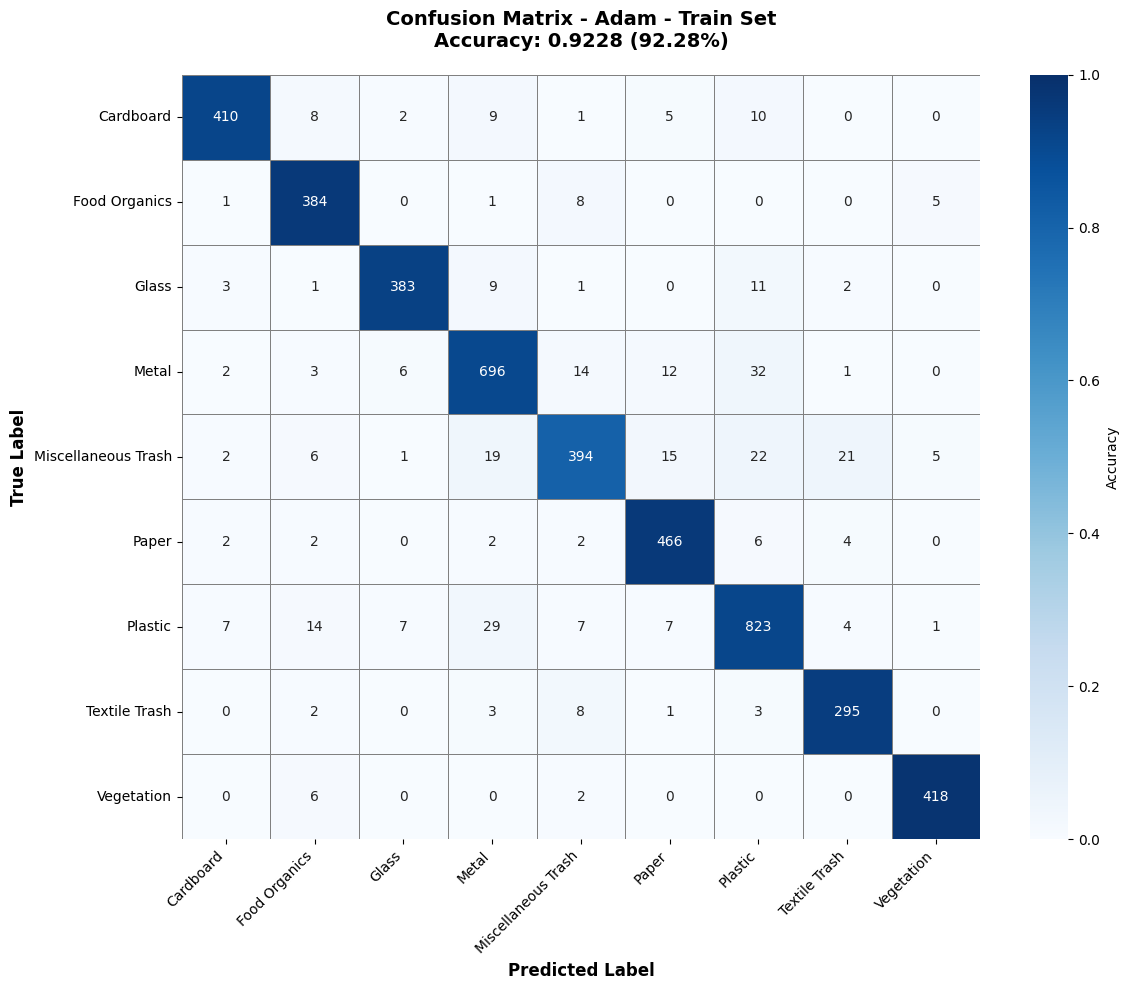

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_Adam_Validation.png


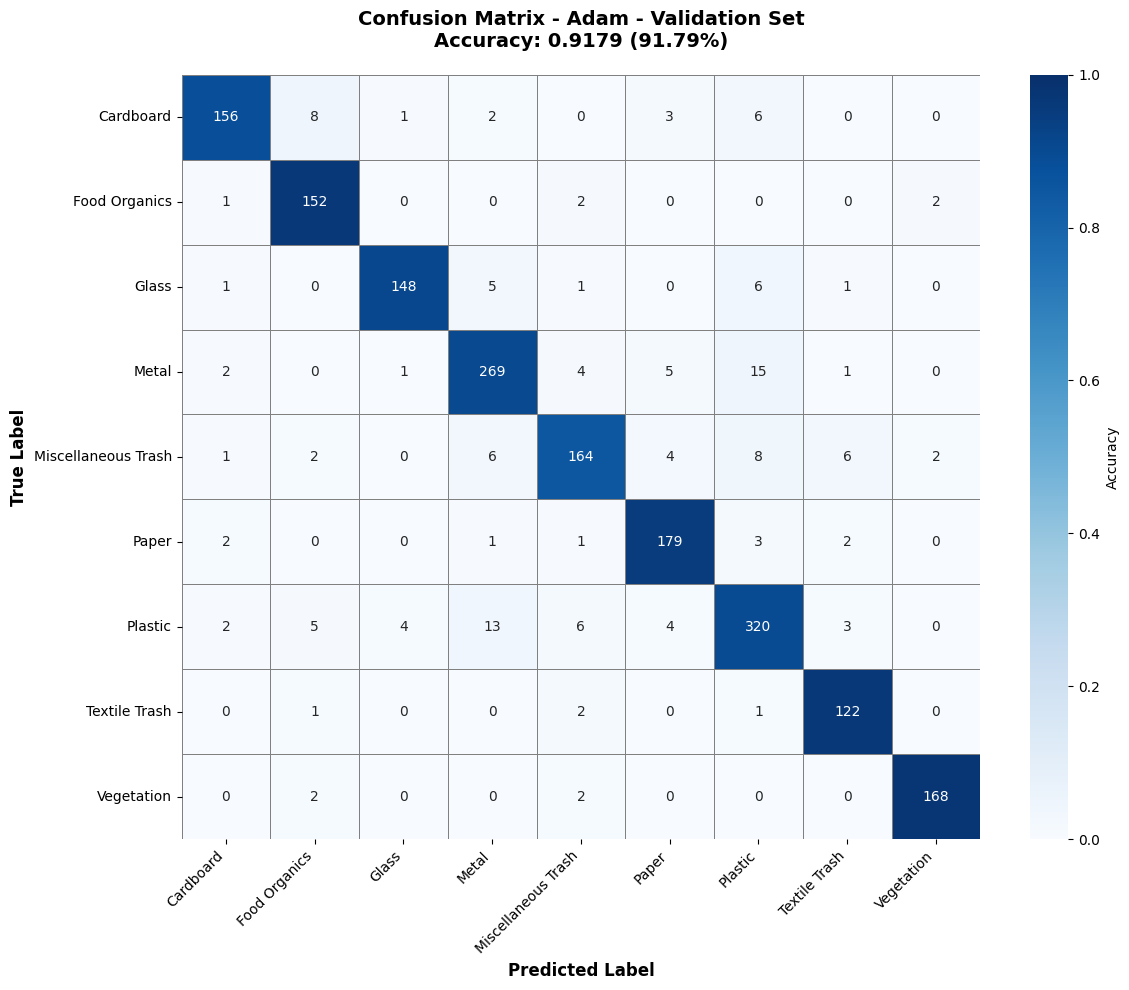

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_Adam_Test.png


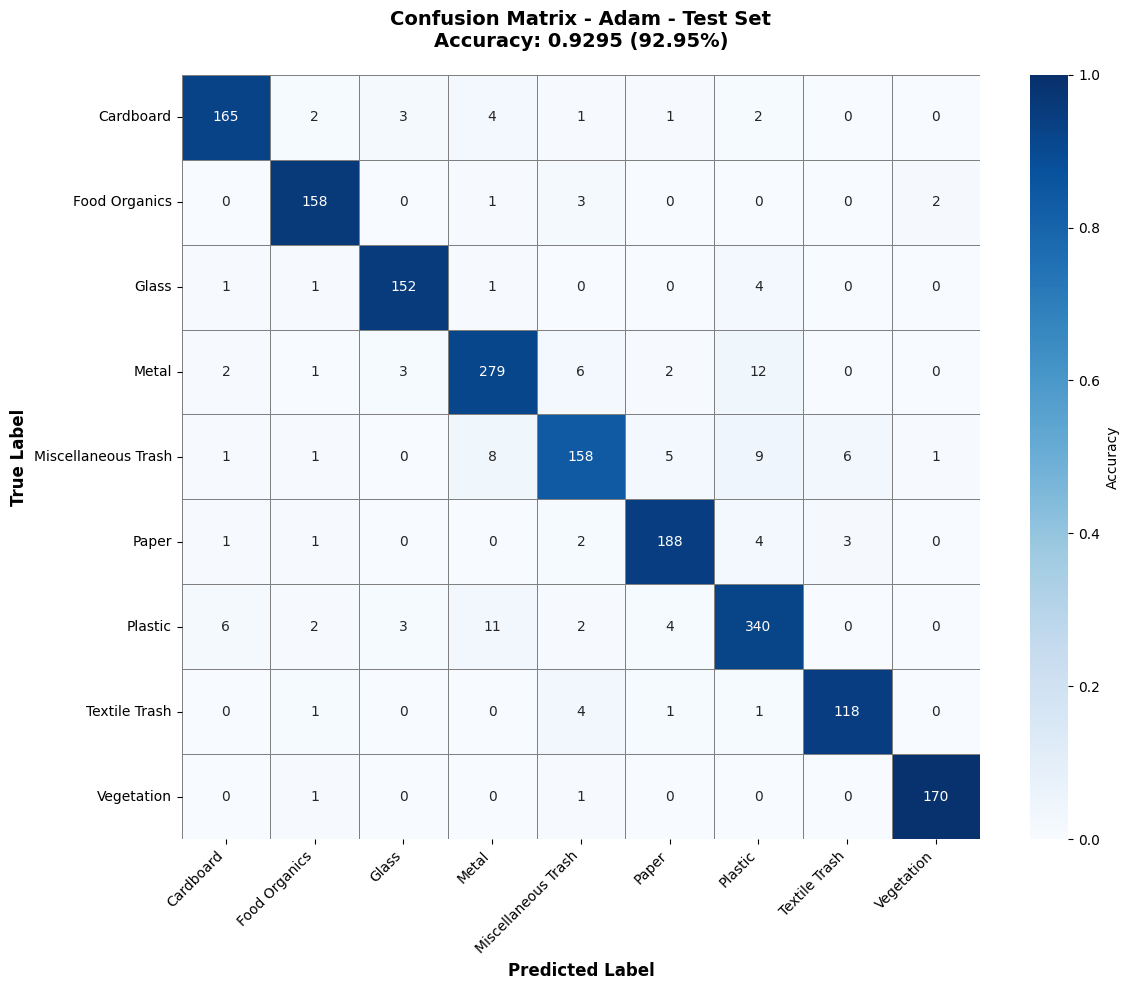

In [27]:
optimizer_name = 'Adam'
print(f"\nGenerating confusion matrices for {optimizer_name} optimizer...\n")

for dataset_name in ['Train', 'Validation', 'Test']:
    y_true = results[optimizer_name][dataset_name]['y_true']
    y_pred = results[optimizer_name][dataset_name]['y_pred']
    accuracy = results[optimizer_name][dataset_name]['accuracy']
    
    title = f'Confusion Matrix - {optimizer_name} - {dataset_name} Set\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)'
    save_path = os.path.join(OUTPUT_DIR, f'confusion_matrix_{optimizer_name}_{dataset_name}.png')
    
    cm, cm_norm = plot_confusion_matrix(y_true, y_pred, class_names, title, save_path)

## 9. Confusion Matrices - SGD Optimizer


Generating confusion matrices for SGD optimizer...

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD_Train.png
Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD_Train.png


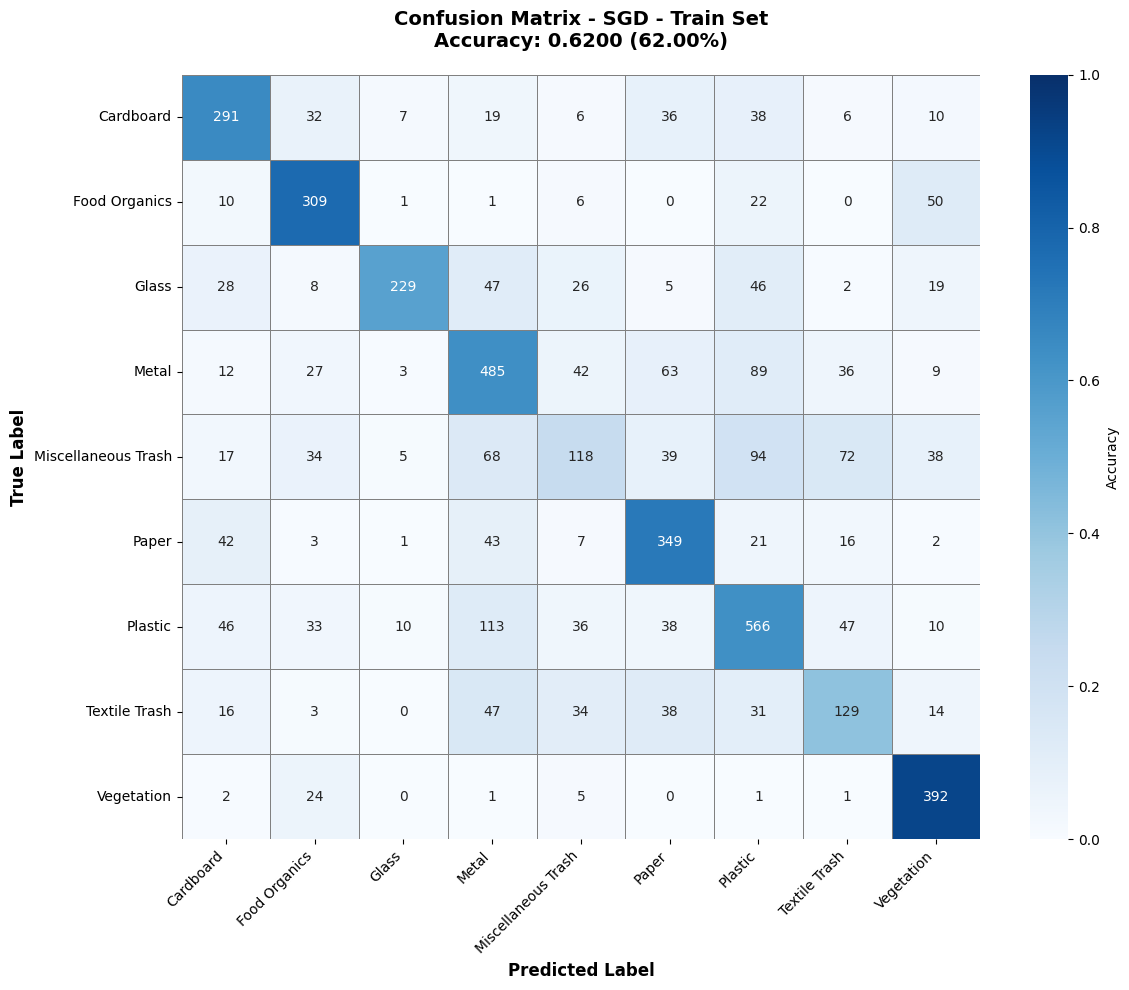

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD_Validation.png


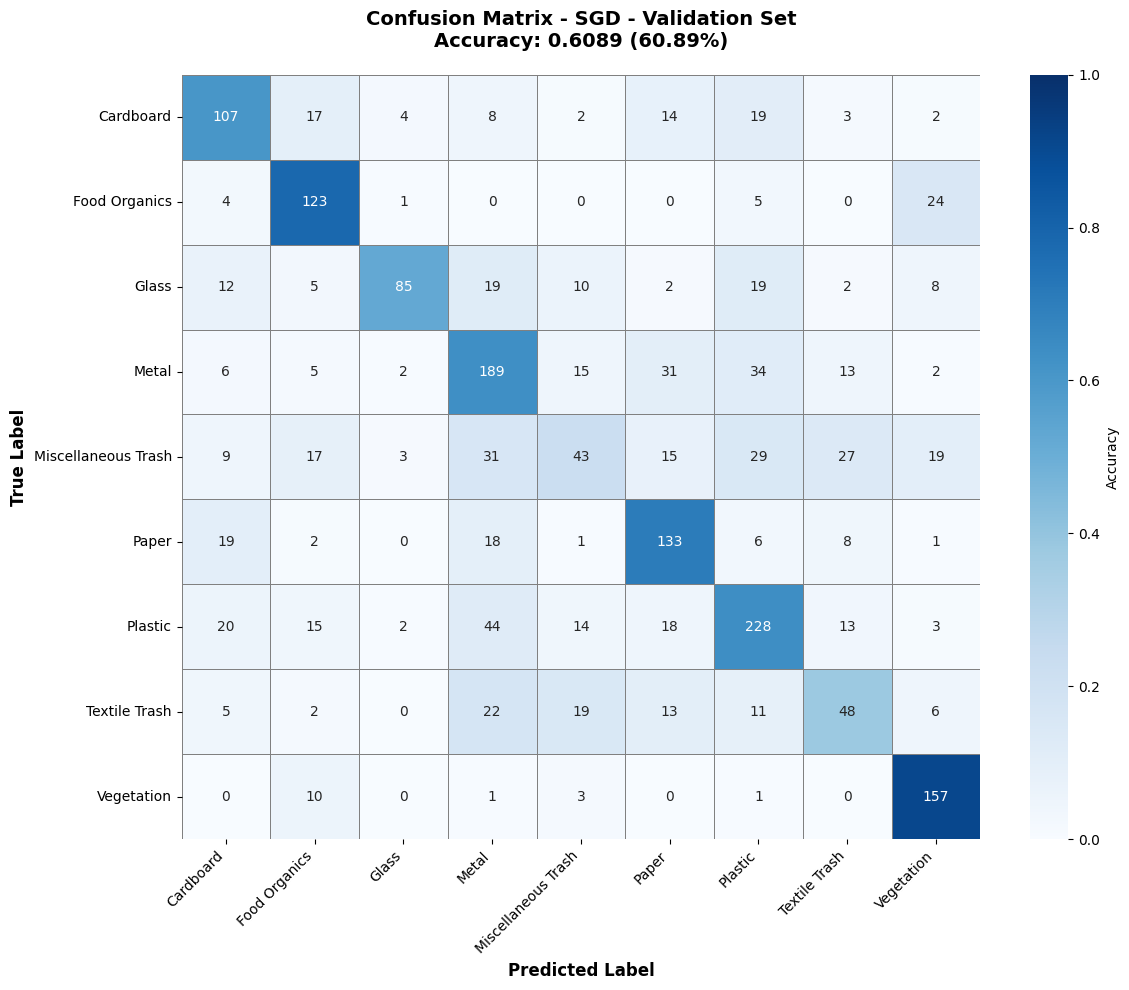

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD_Test.png


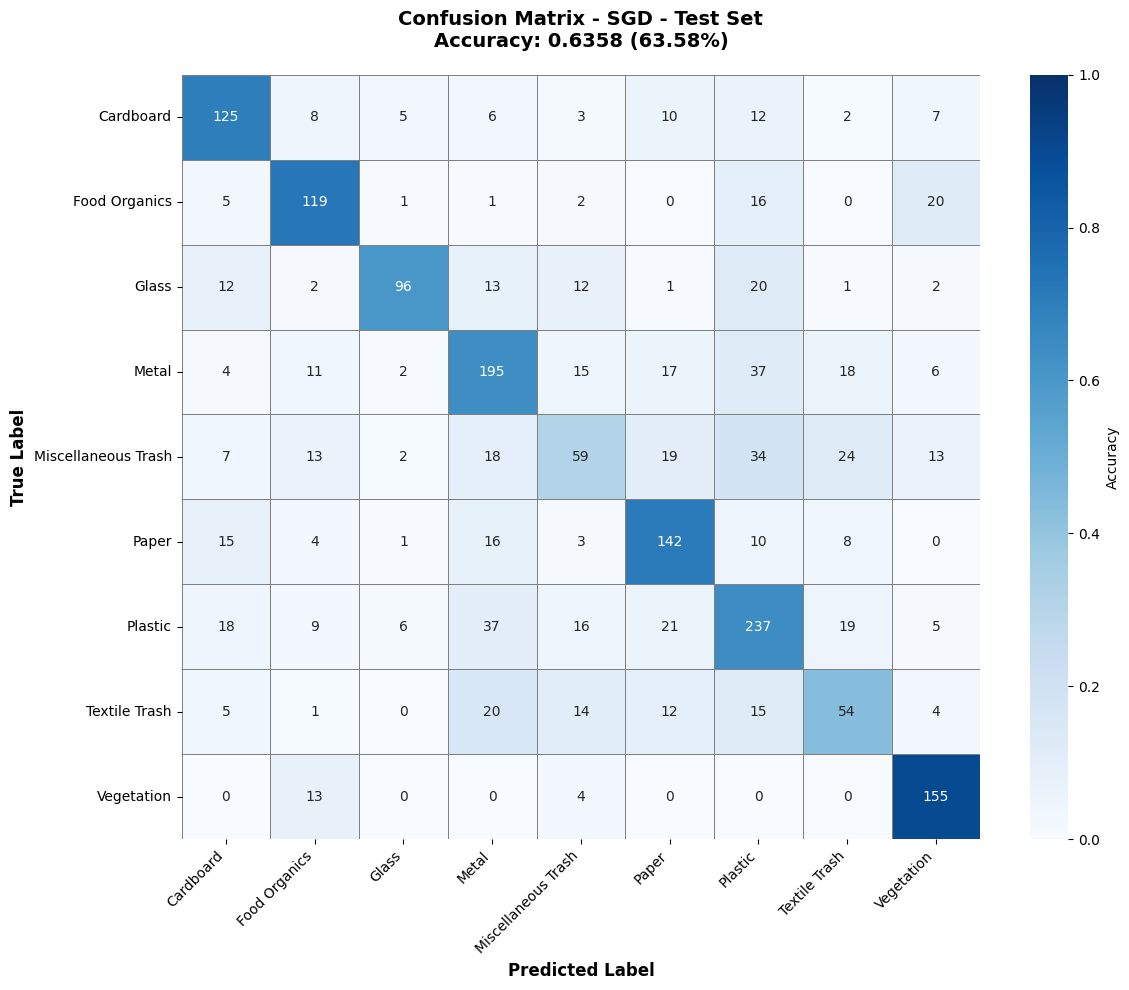

In [28]:
optimizer_name = 'SGD'
print(f"\nGenerating confusion matrices for {optimizer_name} optimizer...\n")

for dataset_name in ['Train', 'Validation', 'Test']:
    y_true = results[optimizer_name][dataset_name]['y_true']
    y_pred = results[optimizer_name][dataset_name]['y_pred']
    accuracy = results[optimizer_name][dataset_name]['accuracy']
    
    title = f'Confusion Matrix - {optimizer_name} - {dataset_name} Set\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)'
    save_path = os.path.join(OUTPUT_DIR, f'confusion_matrix_{optimizer_name}_{dataset_name}.png')
    
    cm, cm_norm = plot_confusion_matrix(y_true, y_pred, class_names, title, save_path)

## 10. Confusion Matrices - SGD+Momentum Optimizer


Generating confusion matrices for SGD+Momentum optimizer...

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD+Momentum_Train.png
Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD+Momentum_Train.png


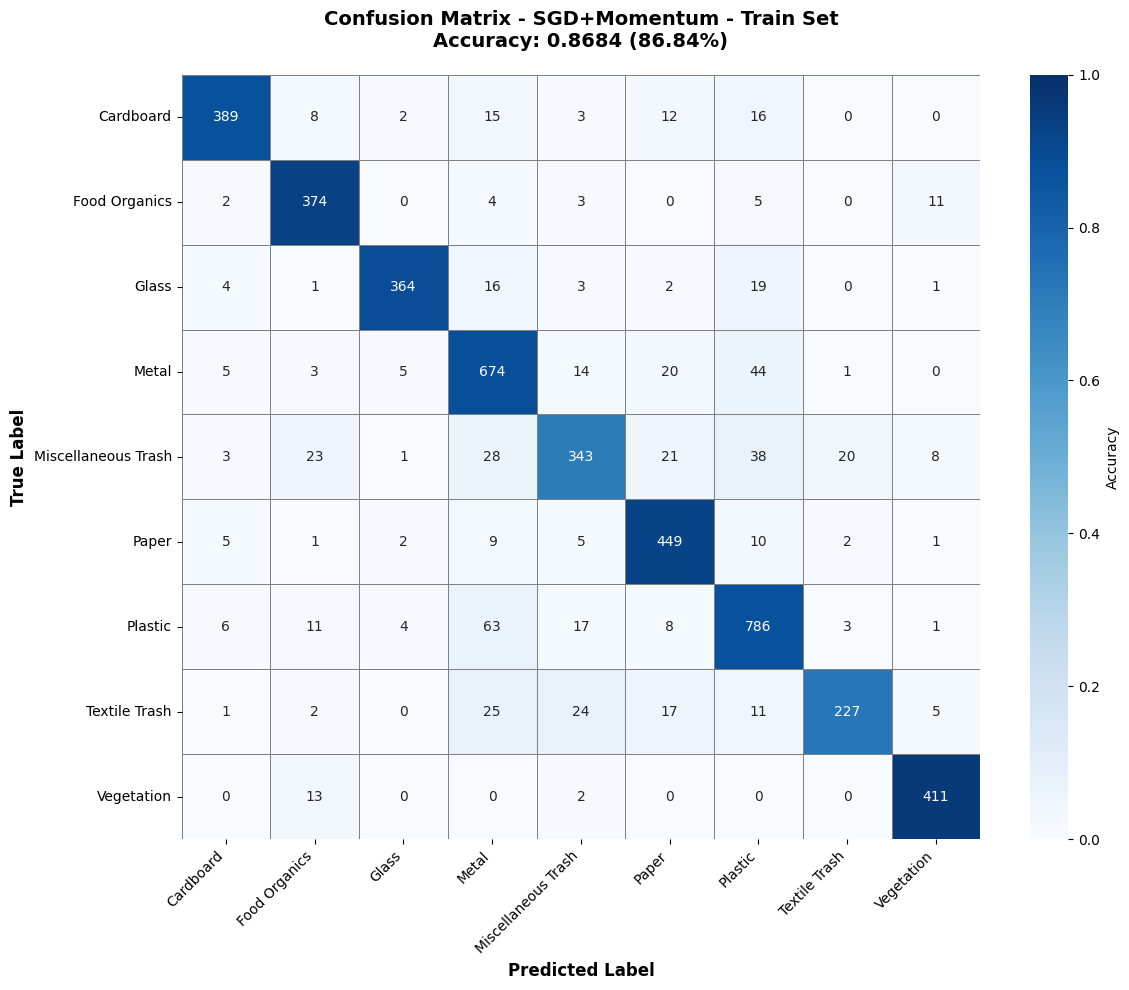

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD+Momentum_Validation.png


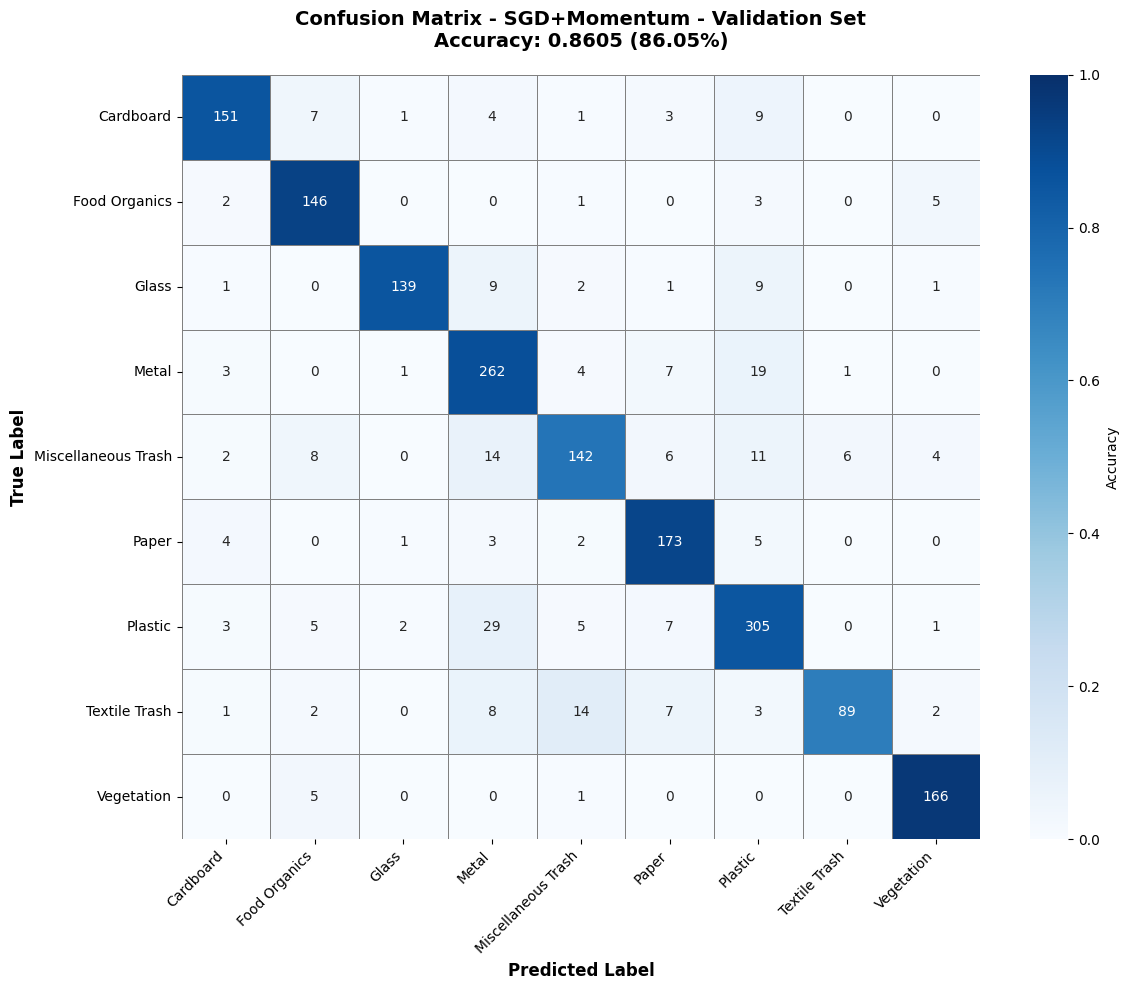

Confusion matrix saved to: results leakyrelu 03/evaluation\confusion_matrix_SGD+Momentum_Test.png


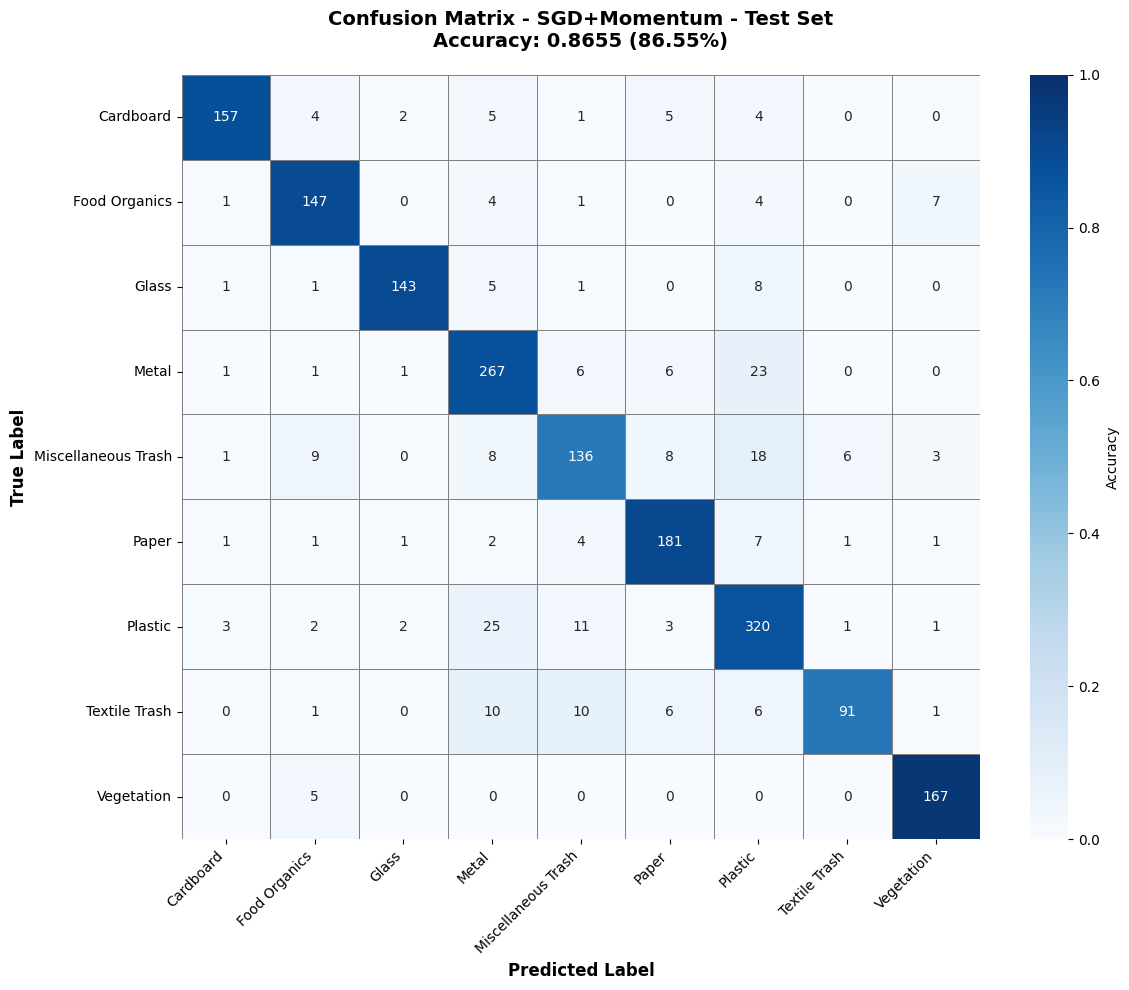

In [29]:
optimizer_name = 'SGD+Momentum'
print(f"\nGenerating confusion matrices for {optimizer_name} optimizer...\n")

for dataset_name in ['Train', 'Validation', 'Test']:
    y_true = results[optimizer_name][dataset_name]['y_true']
    y_pred = results[optimizer_name][dataset_name]['y_pred']
    accuracy = results[optimizer_name][dataset_name]['accuracy']
    
    title = f'Confusion Matrix - {optimizer_name} - {dataset_name} Set\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)'
    save_path = os.path.join(OUTPUT_DIR, f'confusion_matrix_{optimizer_name}_{dataset_name}.png')
    
    cm, cm_norm = plot_confusion_matrix(y_true, y_pred, class_names, title, save_path)

## 11. Comparative Analysis - Overall Accuracies

In [30]:
# Create comparison DataFrame
comparison_data = []

for optimizer_name in results.keys():
    row = {'Optimizer': optimizer_name}
    for dataset_name in ['Train', 'Validation', 'Test']:
        accuracy = results[optimizer_name][dataset_name]['accuracy']
        row[f'{dataset_name} Accuracy'] = f"{accuracy:.4f} ({accuracy*100:.2f}%)"
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*100)
print("Overall Accuracy Comparison Across All Models and Datasets")
print("="*100 + "\n")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_path = os.path.join(OUTPUT_DIR, 'overall_accuracy_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparison saved to: {comparison_path}")


Overall Accuracy Comparison Across All Models and Datasets

   Optimizer  Train Accuracy Validation Accuracy   Test Accuracy
        Adam 0.9228 (92.28%)     0.9179 (91.79%) 0.9295 (92.95%)
         SGD 0.6200 (62.00%)     0.6089 (60.89%) 0.6358 (63.58%)
SGD+Momentum 0.8684 (86.84%)     0.8605 (86.05%) 0.8655 (86.55%)

✓ Comparison saved to: results leakyrelu 03/evaluation\overall_accuracy_comparison.csv


## 12. Comparative Visualization - Accuracy Bar Plot


✓ Comparison plot saved to: results leakyrelu 03/evaluation\accuracy_comparison_barplot.png


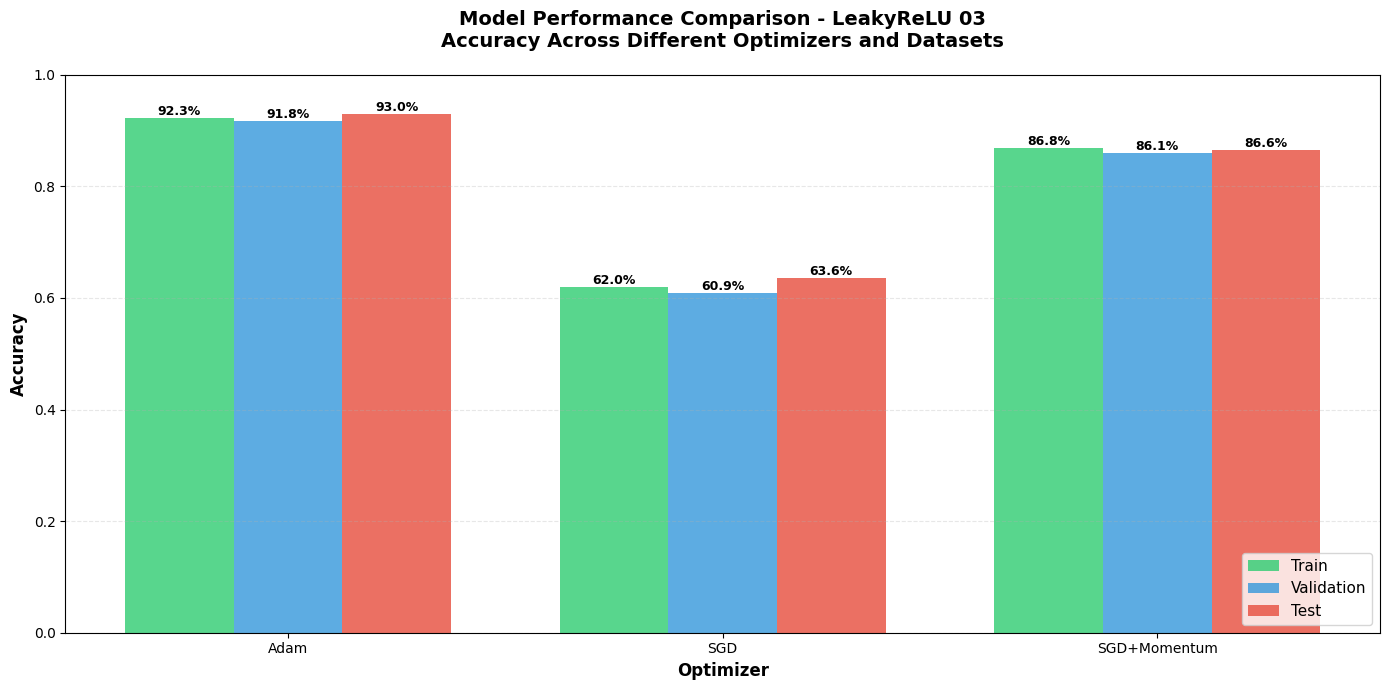

In [31]:
# Prepare data for plotting
plot_data = []
for optimizer_name in results.keys():
    for dataset_name in ['Train', 'Validation', 'Test']:
        accuracy = results[optimizer_name][dataset_name]['accuracy']
        plot_data.append({
            'Optimizer': optimizer_name,
            'Dataset': dataset_name,
            'Accuracy': accuracy
        })

plot_df = pd.DataFrame(plot_data)

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(14, 7))

optimizers = plot_df['Optimizer'].unique()
datasets = ['Train', 'Validation', 'Test']
x = np.arange(len(optimizers))
width = 0.25

colors = ['#2ecc71', '#3498db', '#e74c3c']

for i, dataset in enumerate(datasets):
    accuracies = [plot_df[(plot_df['Optimizer'] == opt) & (plot_df['Dataset'] == dataset)]['Accuracy'].values[0] 
                  for opt in optimizers]
    bars = ax.bar(x + i*width, accuracies, width, label=dataset, color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Optimizer', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison - LeakyReLU 03\nAccuracy Across Different Optimizers and Datasets', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(optimizers)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.0])

plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'accuracy_comparison_barplot.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to: {save_path}")
plt.show()

## 13. Class-wise Performance Comparison - Test Data


✓ Class-wise comparison plot saved to: results leakyrelu 03/evaluation\classwise_f1_comparison.png


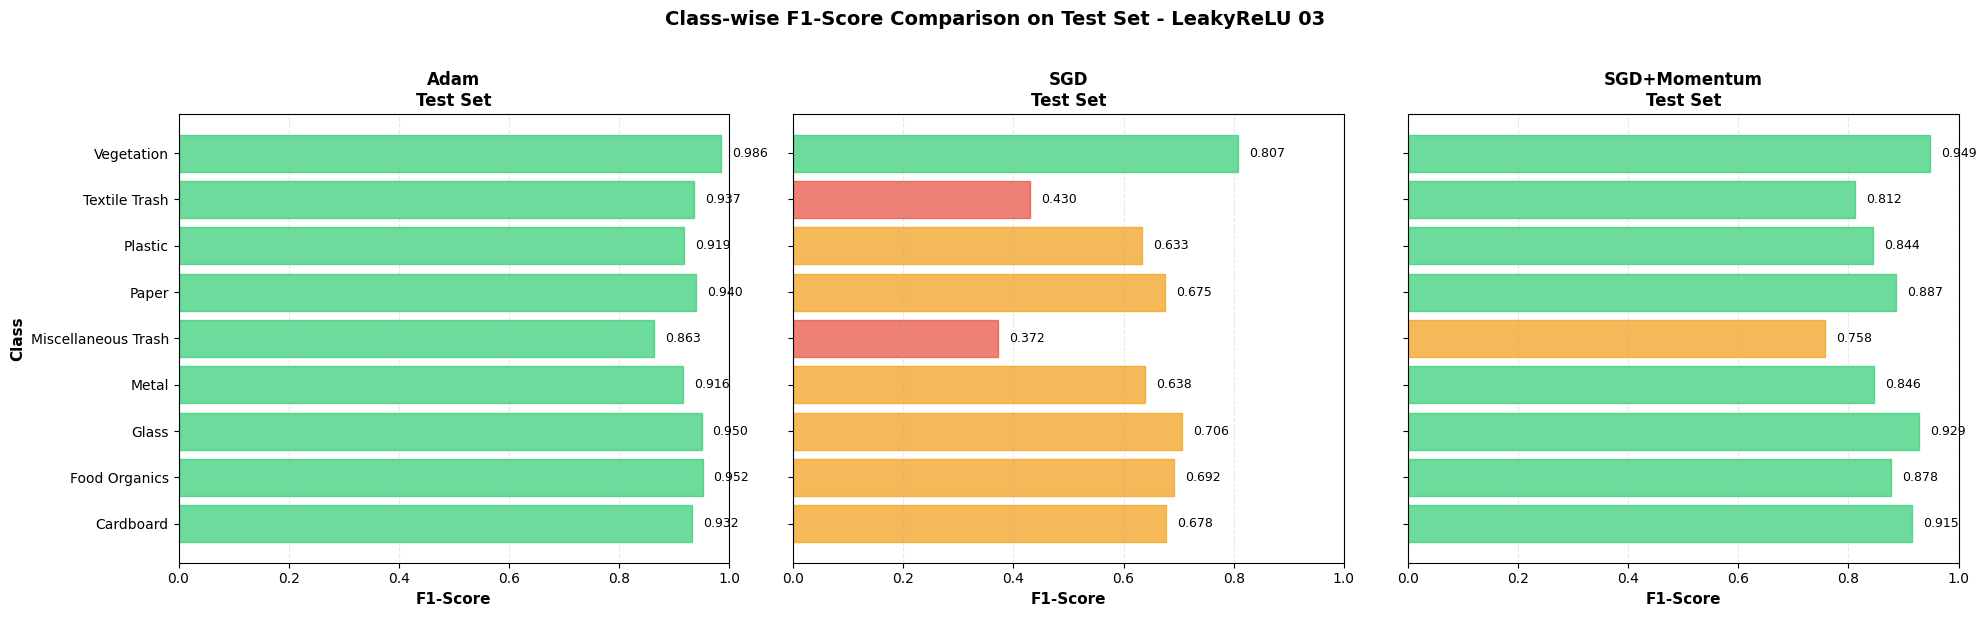

In [32]:
# Compare class-wise F1-scores across optimizers for Test set
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for idx, optimizer_name in enumerate(results.keys()):
    metrics_df = results[optimizer_name]['Test']['metrics_df']
    
    ax = axes[idx]
    bars = ax.barh(metrics_df['Class'], metrics_df['F1-Score'], color='steelblue', alpha=0.7)
    
    # Color bars by performance
    for i, (bar, f1) in enumerate(zip(bars, metrics_df['F1-Score'])):
        if f1 >= 0.8:
            bar.set_color('#2ecc71')  # Green
        elif f1 >= 0.6:
            bar.set_color('#f39c12')  # Orange
        else:
            bar.set_color('#e74c3c')  # Red
    
    ax.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{optimizer_name}\nTest Set', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (cls, f1) in enumerate(zip(metrics_df['Class'], metrics_df['F1-Score'])):
        ax.text(f1 + 0.02, i, f'{f1:.3f}', va='center', fontsize=9)

axes[0].set_ylabel('Class', fontsize=11, fontweight='bold')

plt.suptitle('Class-wise F1-Score Comparison on Test Set - LeakyReLU 03', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = os.path.join(OUTPUT_DIR, 'classwise_f1_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class-wise comparison plot saved to: {save_path}")
plt.show()

## 13.1 Class-wise Performance - Training Data


✓ Class-wise comparison plot (Training) saved to: results leakyrelu 03/evaluation\classwise_f1_comparison_train.png


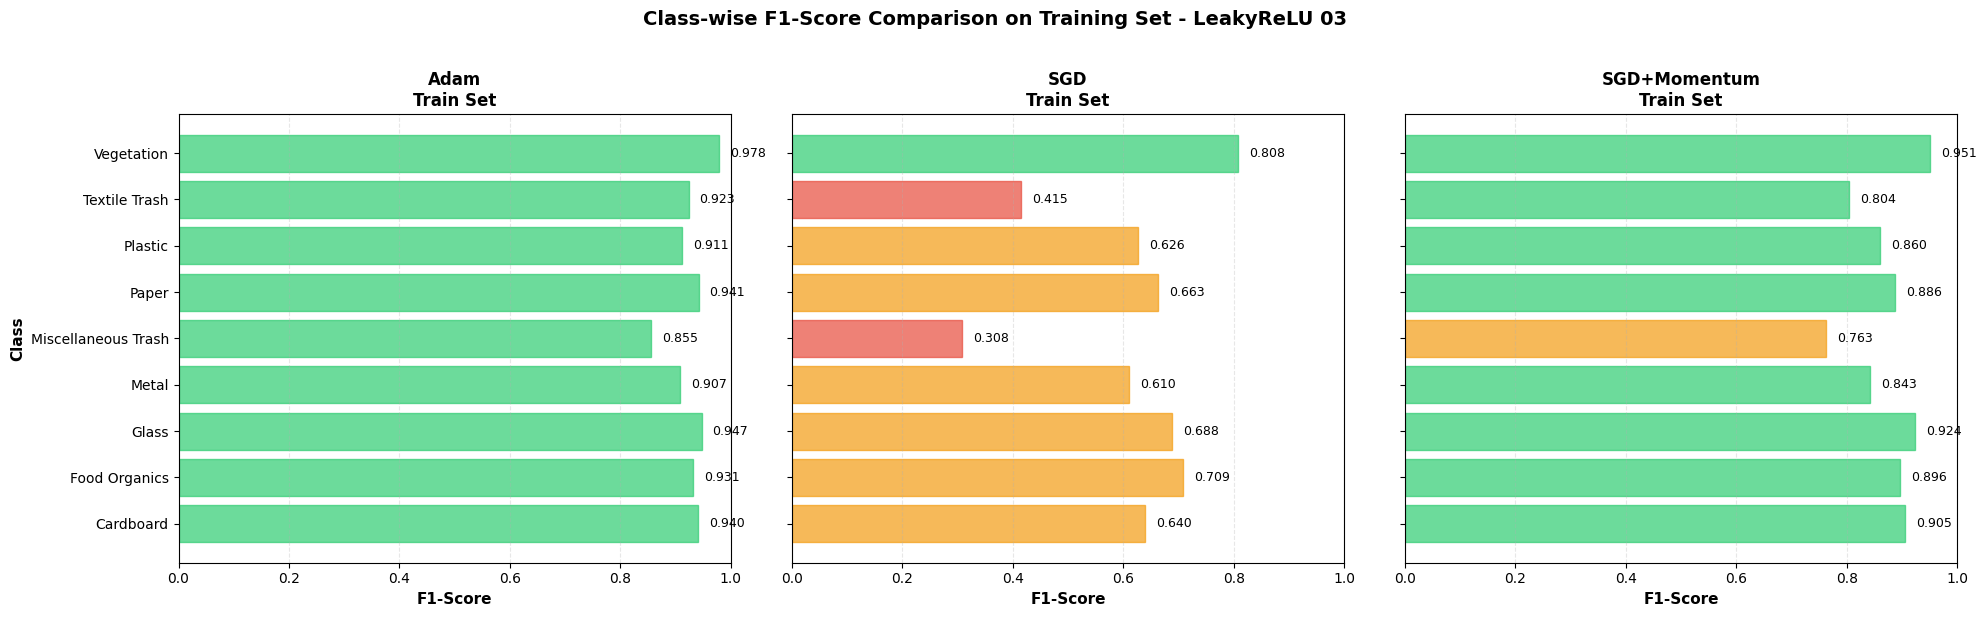

In [33]:
# Compare class-wise F1-scores across optimizers for Training set
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for idx, optimizer_name in enumerate(results.keys()):
    metrics_df = results[optimizer_name]['Train']['metrics_df']
    
    ax = axes[idx]
    bars = ax.barh(metrics_df['Class'], metrics_df['F1-Score'], color='steelblue', alpha=0.7)
    
    # Color bars by performance
    for i, (bar, f1) in enumerate(zip(bars, metrics_df['F1-Score'])):
        if f1 >= 0.8:
            bar.set_color('#2ecc71')  # Green
        elif f1 >= 0.6:
            bar.set_color('#f39c12')  # Orange
        else:
            bar.set_color('#e74c3c')  # Red
    
    ax.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{optimizer_name}\nTrain Set', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (cls, f1) in enumerate(zip(metrics_df['Class'], metrics_df['F1-Score'])):
        ax.text(f1 + 0.02, i, f'{f1:.3f}', va='center', fontsize=9)

axes[0].set_ylabel('Class', fontsize=11, fontweight='bold')

plt.suptitle('Class-wise F1-Score Comparison on Training Set - LeakyReLU 03', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = os.path.join(OUTPUT_DIR, 'classwise_f1_comparison_train.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class-wise comparison plot (Training) saved to: {save_path}")
plt.show()

## 13.2 Class-wise Performance - Validation Data


✓ Class-wise comparison plot (Validation) saved to: results leakyrelu 03/evaluation\classwise_f1_comparison_validation.png


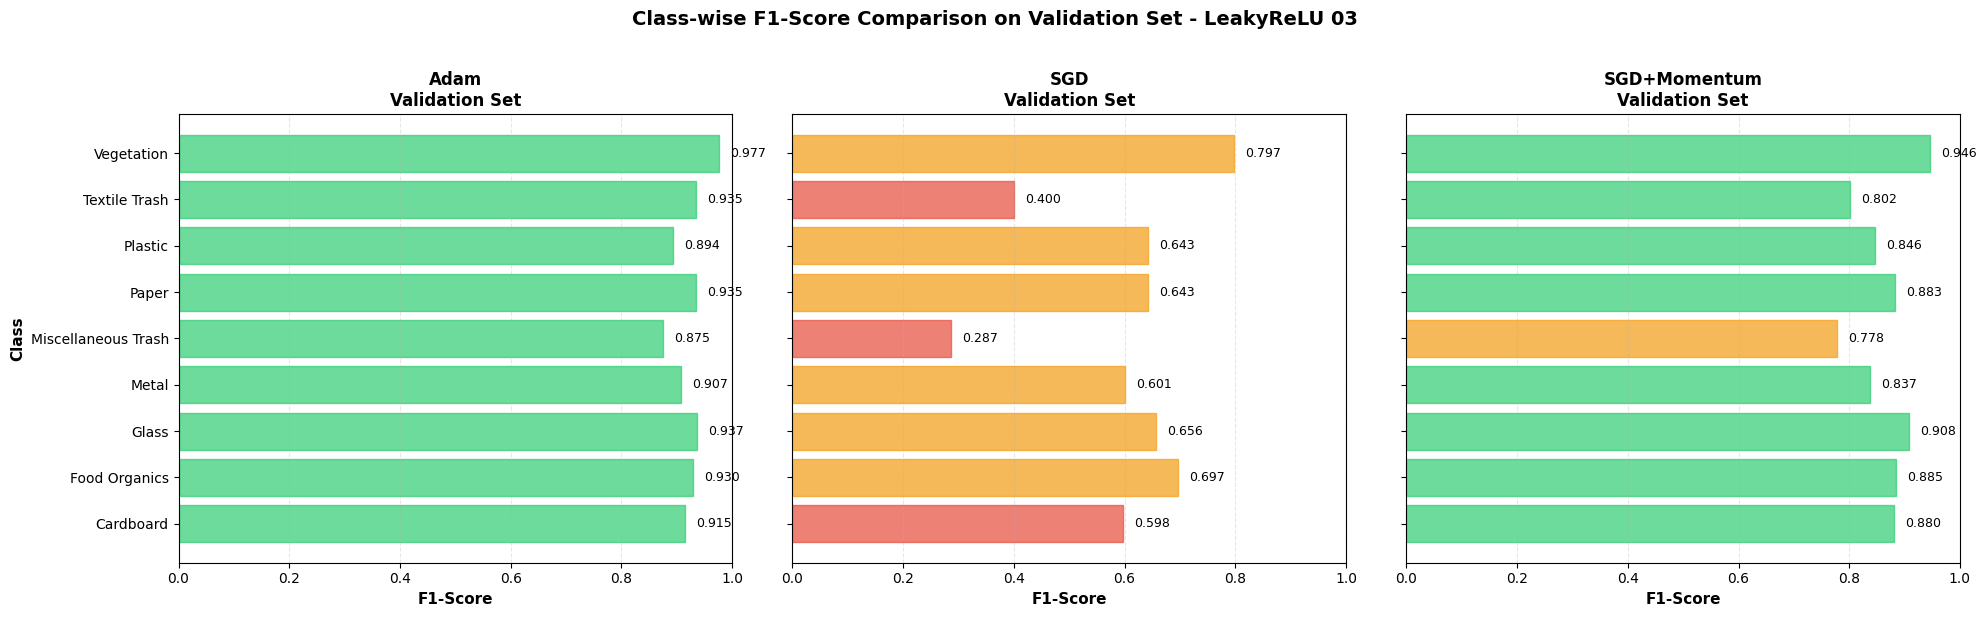

In [34]:
# Compare class-wise F1-scores across optimizers for Validation set
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for idx, optimizer_name in enumerate(results.keys()):
    metrics_df = results[optimizer_name]['Validation']['metrics_df']
    
    ax = axes[idx]
    bars = ax.barh(metrics_df['Class'], metrics_df['F1-Score'], color='steelblue', alpha=0.7)
    
    # Color bars by performance
    for i, (bar, f1) in enumerate(zip(bars, metrics_df['F1-Score'])):
        if f1 >= 0.8:
            bar.set_color('#2ecc71')  # Green
        elif f1 >= 0.6:
            bar.set_color('#f39c12')  # Orange
        else:
            bar.set_color('#e74c3c')  # Red
    
    ax.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{optimizer_name}\nValidation Set', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (cls, f1) in enumerate(zip(metrics_df['Class'], metrics_df['F1-Score'])):
        ax.text(f1 + 0.02, i, f'{f1:.3f}', va='center', fontsize=9)

axes[0].set_ylabel('Class', fontsize=11, fontweight='bold')

plt.suptitle('Class-wise F1-Score Comparison on Validation Set - LeakyReLU 03', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = os.path.join(OUTPUT_DIR, 'classwise_f1_comparison_validation.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class-wise comparison plot (Validation) saved to: {save_path}")
plt.show()

## 14. Summary Report

In [35]:
# Generate summary report
print("\n" + "="*100)
print("EVALUATION SUMMARY - LeakyReLU 03 Models")
print("="*100 + "\n")

print(f"Models Evaluated: {len(results)}")
print(f"Optimizers: {', '.join(results.keys())}")
print(f"Datasets: Train, Validation, Test")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {', '.join(class_names)}")
print(f"\nTotal Samples:")
print(f"  - Training: {len(train_loader.dataset):,}")
print(f"  - Validation: {len(val_loader.dataset):,}")
print(f"  - Test: {len(test_loader.dataset):,}")

print(f"\n" + "-"*100)
print("Best Performing Model by Dataset:")
print("-"*100)

for dataset_name in ['Train', 'Validation', 'Test']:
    best_acc = 0
    best_opt = None
    
    for optimizer_name in results.keys():
        acc = results[optimizer_name][dataset_name]['accuracy']
        if acc > best_acc:
            best_acc = acc
            best_opt = optimizer_name
    
    print(f"  {dataset_name:12s}: {best_opt:15s} - Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

print(f"\n" + "-"*100)
print("Output Files Generated:")
print("-"*100)
print(f"  - Location: {OUTPUT_DIR}")
print(f"  - Confusion Matrices: 9 PNG files (3 optimizers × 3 datasets)")
print(f"  - Class-wise Metrics: 9 CSV files (3 optimizers × 3 datasets)")
print(f"  - Comparison Files: 2 files (CSV + PNG)")
print(f"  - Class-wise F1 Comparison: 1 PNG file")

print(f"\n" + "="*100)
print("Evaluation completed successfully!")
print("="*100 + "\n")


EVALUATION SUMMARY - LeakyReLU 03 Models

Models Evaluated: 3
Optimizers: Adam, SGD, SGD+Momentum
Datasets: Train, Validation, Test
Number of Classes: 9
Classes: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation

Total Samples:
  - Training: 4,626
  - Validation: 1,828
  - Test: 1,859

----------------------------------------------------------------------------------------------------
Best Performing Model by Dataset:
----------------------------------------------------------------------------------------------------
  Train       : Adam            - Accuracy: 0.9228 (92.28%)
  Validation  : Adam            - Accuracy: 0.9179 (91.79%)
  Test        : Adam            - Accuracy: 0.9295 (92.95%)

----------------------------------------------------------------------------------------------------
Output Files Generated:
----------------------------------------------------------------------------------------------------
  - Location: re